<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Leroy Deniz Pedreira
</div>

# PEC 1 - Soluciones tabulares

En esta práctica implementaremos los diferentes métodos de aprendizaje por refuerzo vistos en las partes I y II del curso. En concreto, nos centraremos en la definición de un entorno e implementaremos los diferentes métodos para buscar una solución óptima del problema.

<u>Consideraciones generales</u>: 

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. El entorno __BlackJack__

El entorno __BlackJack__ simula una partida de blackjack, que se juega con una baraja francesa de 52 cartas (baraja de póker), constituída por 4 palos (trébol ♣, corazones ♥, picas ♠, y diamantes ♦) y 13 cartas por palo (As, los números del 2 al 10, J, Q y K).

El objetivo de este juego es obtener cartas cuyo valor numérico sumen el número
mayor posible sin exceder de 21.

Todas aquellas cartas con un valor numérico cuentan como dicho valor numérico,
las figuras (J, Q y K) cuentan como un 10, y el as puede contar como
un 1 (en este caso se denomina as no usable) o como un 11 (en este caso se denomina as usable).

En la siguiente figura puede observarse el valor numérico de todos los tipos de cartas:<br>

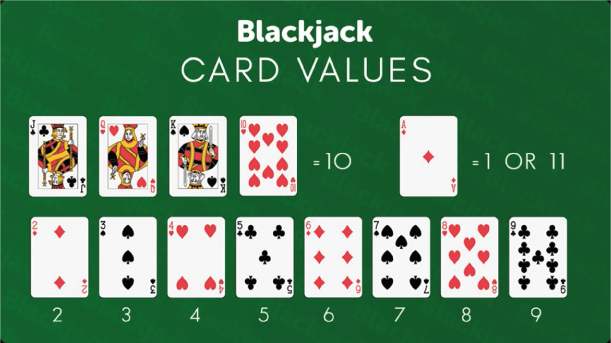

**Figura 1. El juego del Blackjack.** (Fuente: Sutton & Barto, 1998)

Las normas del juego están explicadas en el módulo 5 de la asignatura.

Jugar al blackjack puede ser formulado de forma natural como un MDP finito
y episódico

• Cada partida de blackjack es un episodio.<br>
• Las recompensas son: +1 por ganar, -1 por perder y 0 por empatar.<br>
• El retorno se calcula sin descuento (γ = 1).<br>
• El conjunto de acciones del jugador son pedir carta (hit) o plantarse (stick).
Es decir: A = {hit,stick}.<br>
• Los estados dependen de las cartas del jugador y de la carta que muestra el
crupier.<br>
• El jugador toma decisiones basándose en tres variables:<br>
    – Si le ha salido un as que pueda contar como 11 sin pasarse (usable ace en
inglés).<br>
    – La suma actual de sus cartas (de 12 a 21).<br>
    – El valor de la carta boca arriba del crupier.<br>
• Esto hace un total de 200 estados distintos.<br>

El entorno que utilizaremos inicialmente implementa todas las características comentadas anteriormente y la siguiente política para el crupier:


• Se planta si su suma es 17 o mayor, pide carta en otro caso.


El código para implementar este entorno se encuentra disponible en el fichero adjunto `blackjack_env.py`

Vamos a empezar cargando el entorno y ver qué características tiene, ejecutando un episodio de prueba.

### 0.1. Carga de datos
El siguiente código carga los paquetes necesarios para ejecutar el ejemplo, crea el entorno mediante la instanciación de un objeto de la clase `BlackjackEnv` (importada del archivo adjunto `blackjack_env.py`) e imprime por pantalla la dimensión del espacio de acciones (0=plantarse, 1=pedir carta), del espacio de observaciones (una tupla de 3 elementos: la suma actual del jugador, la carta que muestra el crupier con valores 1-10, donde 1 es un as, y si el jugador tiene o no un as utilizable) y el rango de la variable de recompensa (cuyo valor es -1, 0 o 1 dependiendo de si el jugador pierde, empata o gana la partida y que por tanto va de menos infinito a más infinito).

In [1]:
#Ejecutar esta celda sólo si ejecutamos este notebook en Google Colab desde Drive
#from google.colab import drive
#drive.mount('/content/drive')
#MODIFICAR ACORDE A LA RUTA DE TUS CARPETAS
#%cd /content/drive/My Drive/AR/PEC1/

In [2]:
import numpy as np
import blackjack_env as bj1

# Custom imports
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import time
import datetime
import statistics
from collections import defaultdict
from abc import ABC, abstractmethod

env=bj1.BlackjackEnv()
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))
print("Reward range is {} ".format(env.reward_range))

Action space is Discrete(2) 
Observation space is Tuple(Discrete(32), Discrete(11), Discrete(2)) 
Reward range is (-inf, inf) 


### 0.2. Ejecución de un episodio

A continuación, realizaremos la ejecución de un episodio del entorno `BlackjackEnv` utilizando un agente que selecciona las acciones de forma aleatoria.


In [3]:
# Inicializamos el entorno
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial: Player = {}, Dealer = {}, Usable Ace = {} ".format(obs[0],obs[1],obs[2]))

switch_action = {
    
        0: "Stick",
        1: "Hit",
    }

while not done:
    
    # Elegir una acción aleatoria (ésta es la implementación del agente)
    action = env.action_space.sample()
    
    # Ejecutar la acción y esperar la respuesta del entorno
    new_obs, reward, done, info = env.step(action)
    
    # Imprimir time-step
    print("Action: {} -> Obs: Player = {}, Dealer = {}, Usable Ace = {} and reward: {}".format(switch_action[action], new_obs[0],new_obs[1],new_obs[2], reward))
    
    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1
    
print("Episodio finalizado después de {} pasos y la recompensa fue {} ".format(t, total_reward))
env.close()

Obs inicial: Player = 17, Dealer = 4, Usable Ace = True 
Action: Hit -> Obs: Player = 21, Dealer = 4, Usable Ace = True and reward: 0
Action: Stick -> Obs: Player = 21, Dealer = 4, Usable Ace = True and reward: 1
Episodio finalizado después de 2 pasos y la recompensa fue 1 


## 1. Análisis y Modificación del entorno (2 puntos)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1</strong> (0,5 puntos)</div>

Analizar el código del fichero del entorno (fichero adjunto `blacjack_env.py`) y documentar todas las funciones (rellenar los comentarios donde pone `""" Descripción """`).

Guardar el archivo con el mismo nombre `blackjack_env.py`. Este archivo debe entregarse junto a los archivos de este notebook (.ipynb y .html).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2</strong> (0,5 puntos)</div>

En el juego de Blackjack que se juega en los casinos hay una pequeña diferencia en cuanto a las recompensas: si un jugador gana una partida con un natural (las 2 primeras cartas suman 21) recibe una recompensa de 1,5 puntos.

Una explicación se puede encontrar en el siguiente [enlace](http://www.bicyclecards.com/how-to-play/blackjack/).

Modificar el codigo de BlackjackEnv (fichero adjunto `blacjack_env.py`) para que otorgue una puntuación de 1,5 en caso de que el jugador tenga un natural de mano y el crupier no.

Guardar el entorno modificado en el archivo `blackjack_env_v2.py`, en la misma carpeta que el original. Este archivo debe entregarse junto a los archivos de este notebook (.ipynb y .html) y el entorno original documentado.

In [4]:
import gym
import blackjack_env_v2 as bj2

env=bj2.BlackjackEnv()
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))
print("Reward range is {} ".format(env.reward_range))

Action space is Discrete(2) 
Observation space is Tuple(Discrete(32), Discrete(11), Discrete(2)) 
Reward range is (-inf, inf) 


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.3</strong> (0,75 puntos)</div>

A continuación, implementar un agente que lleve a cabo la siguiente política determinista: el agente se plantará si obtiene una puntuación de 20 o 21. 

Jugar partidas hasta que el agente gane la partida mediante un natural para comprobar que la implementación es correcta. Mostrar el resultado de esa partida.

In [5]:
# Inicializamos el entorno
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial: Player = {}, Dealer = {}, Usable Ace = {} ".format(obs[0],obs[1],obs[2]))

switch_action = {
        0: "Stick",
        1: "Hit",
    }

Obs inicial: Player = 17, Dealer = 5, Usable Ace = False 


In [6]:
# Creamos una clase para la generación de acciones según políticas

class ActionPolicyGetter(ABC):
    """
    Interfaz de las políticas de los agentes
    """

    @abstractmethod
    def get_action(self, observation): # interfaz para generar la firma de la función
        """
        Dada una observación, devuelve una acción en función de la política implementada.
        """
        pass
    
class RandomActionPolicyGetter(ActionPolicyGetter):
    """
    Clase que implementa la política de acciones aleatorias
    """
    
    # Slots ofrece un mecanismo especial para reducir el tamaño de los objetos
    __slots__ = ("env",)

    def __init__(self, environment) -> None:
        super().__init__()
        self.env = environment
        
    def get_action(self, observation):
        return self.env.action_space.sample()

class DeterministicActionPolicyGetter(ActionPolicyGetter):
    """
    Clase que implementa la política de plantarse cuando la suma de la baraja del jugador es 20 o 21.
    """
    
    def get_action(self, observation):
        player_sum, _, _ = obs

        if player_sum in [20,21]:
            return 0

        return 1

In [7]:
total_reward = 0
i=0 # Flag para contar las veces que procesa antes de encontrar el natural
policy = DeterministicActionPolicyGetter()

while total_reward != 1.5:
    
    obs = env.reset() # Inicializamos el entorno
    t, total_reward, done = 0, 0, False # Inicializamos las variables pasos, ganancia total y episodio finalizado

    print(f"{i} --> Obs inicial: Player = {obs[0]}, Dealer = {obs[1]}, Usable Ace = {obs[2]} ")

    switch_action = {
        0: "Stick",
        1: "Hit",
    }

    # Mientras el episodio no termine
    while not done:

        # Elegir una acción aleatoria (ésta es la implementación del agente)
        action = policy.get_action(obs)

        # Ejecutar la acción y esperar la respuesta del entorno
        new_obs, reward, done, info = env.step(action)

        # Imprimir time-step
        print(f"Action: {switch_action[action]} -> Obs: Player = {new_obs[0]}, Dealer = {new_obs[1]}, Usable Ace = {new_obs[2]} and reward: {reward}")

        # Actualizar variables
        obs = new_obs
        total_reward += reward
        t += 1

    i+=1
    print(f"Episodio finalizado después de {t} pasos y la recompensa fue {total_reward} \n")
    env.close()
    
print(f"Natural encontrado en la iteración {i}")

0 --> Obs inicial: Player = 21, Dealer = 10, Usable Ace = True 
Action: Stick -> Obs: Player = 21, Dealer = 10, Usable Ace = True and reward: 0
Episodio finalizado después de 1 pasos y la recompensa fue 0 

1 --> Obs inicial: Player = 19, Dealer = 10, Usable Ace = False 
Action: Hit -> Obs: Player = 27, Dealer = 10, Usable Ace = False and reward: -1
Episodio finalizado después de 1 pasos y la recompensa fue -1 

2 --> Obs inicial: Player = 14, Dealer = 7, Usable Ace = False 
Action: Hit -> Obs: Player = 19, Dealer = 7, Usable Ace = False and reward: 0
Action: Hit -> Obs: Player = 29, Dealer = 7, Usable Ace = False and reward: -1
Episodio finalizado después de 2 pasos y la recompensa fue -1 

3 --> Obs inicial: Player = 12, Dealer = 10, Usable Ace = False 
Action: Hit -> Obs: Player = 17, Dealer = 10, Usable Ace = False and reward: 0
Action: Hit -> Obs: Player = 27, Dealer = 10, Usable Ace = False and reward: -1
Episodio finalizado después de 2 pasos y la recompensa fue -1 

4 --> Obs i

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.4</strong> (0,25 puntos)</div>

Utilizando el agente y el entorno del apartado anterior, simular 100.000 partidas y calcular el retorno del agente (recompensa total acumulada).

Calculad el % de victorias, naturales, derrotas y empates. Comentar los resultados.


In [8]:
######################## SOLUCIÓN ###########################

def create_episode(env, sample_policy = None, initial_state = None, initial_action = None):
    # Inicializamos el entorno
    reward, done = 0, False
    states_actions, rewards = [], []
    
    # Extraemos los datos iniciales
    if sample_policy is None:
        sample_policy = RandomActionPolicyGetter()
    
    obs = env.reset() if initial_state is None else initial_state
    action = sample_policy.get_action(obs) if initial_action is None else initial_action
    
    # Inicializamos los vectores
    rewards.append(0) # Recompensa inicial de 0
    states_actions.append((obs, action)) # Primer estado tomado, Primera acción tomada

    # Ejecutamos el episodio
    while not done:
        
        # Ejecutar la acción y esperar la respuesta del entorno
        obs, reward, done, info = env.step(action)
        
        # Generar la acción usando la política
        action = sample_policy.get_action(obs)
        
        # Actualizar variables
        rewards.append(reward) # Almacenar la recompensa inicial, 0 al inicio
        states_actions.append((obs, action)) # Almacenar el estado, Almacenar la acción

    return states_actions, rewards

def play_games_natural(env, sample_policy, games):
    start = time.time()
    victorias, derrotas, empates, naturales, recompensa_acumulada = 0, 0, 0, 0, 0
    
    total_reward = 0
    gamma = 1
    
    i=0 # Flag para contar las veces que procesa antes de encontrar el natural

    # Se ejecutan todos los episodios solicitados por parámetro
    for i in tqdm(range(games), ncols=100, desc=f'Jugando {games} partidas'):
        
        _, rewards = create_episode(env, sample_policy)

        total_reward = sum(rewards)
    
        if total_reward == 1: victorias+=1
        elif total_reward == 0: empates+=1
        elif total_reward == -1: derrotas+=1
        elif total_reward == 1.5: naturales+=1
        
        recompensa_acumulada = recompensa_acumulada + (gamma**(i))*total_reward

        i+=1 # Actualiza el contador de iteraciones
        env.close()
                    
    finish = time.time()
    print(f"Tiempo insumido: {str(datetime.timedelta(seconds=(round(finish-start,0))))}")

    print(f"Victorias: {victorias*100/games}%\nDerrotas: {derrotas*100/games}%\nEmpates: {empates*100/games}%\nNaturales: {naturales*100/games}%\nRecompensa acumulada: {recompensa_acumulada}")

In [9]:
games = 100000
policy = DeterministicActionPolicyGetter()
play_games_natural(env, policy, games)

Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:17<00:00, 5678.10it/s]

Tiempo insumido: 0:00:18
Victorias: 36.979%
Derrotas: 51.847%
Empates: 6.938%
Naturales: 4.236%
Recompensa acumulada: -8514.0


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Siguiendo una política aleatoria, el porcentaje de derrotas oscila en el entorno del 50%, frente a un porcentaje de victorias sobre un 40%, tomando en cuenta las manos naturales. Los empates ascienden a un 7%, lo que hace que las derrotas sean mayoritarias y la recompensa acumulada sea negativo por el impacto de las pérdidas.
</div>


## 2. Política óptima (2 puntos)

Dado que el entorno utilizado en las simulaciones del módulo 5 se ha hecho sin la asiganción extra de 1,5 para el caso de un natural, y con el objetivo de reproducir los mismos resultados, utilizaremos el entorno original proporcionado con el enunciado.

**NOTA IMPORTANTE:** Utilizar el siguiente entorno en el resto de apartados de la PEC

In [10]:
env = bj1.BlackjackEnv()

En el módulo 5 sobre los métodos de Montecarlo se analiza el ejemplo del Blackjack y se resuelve el escenario llegando a la siguiente política óptima:

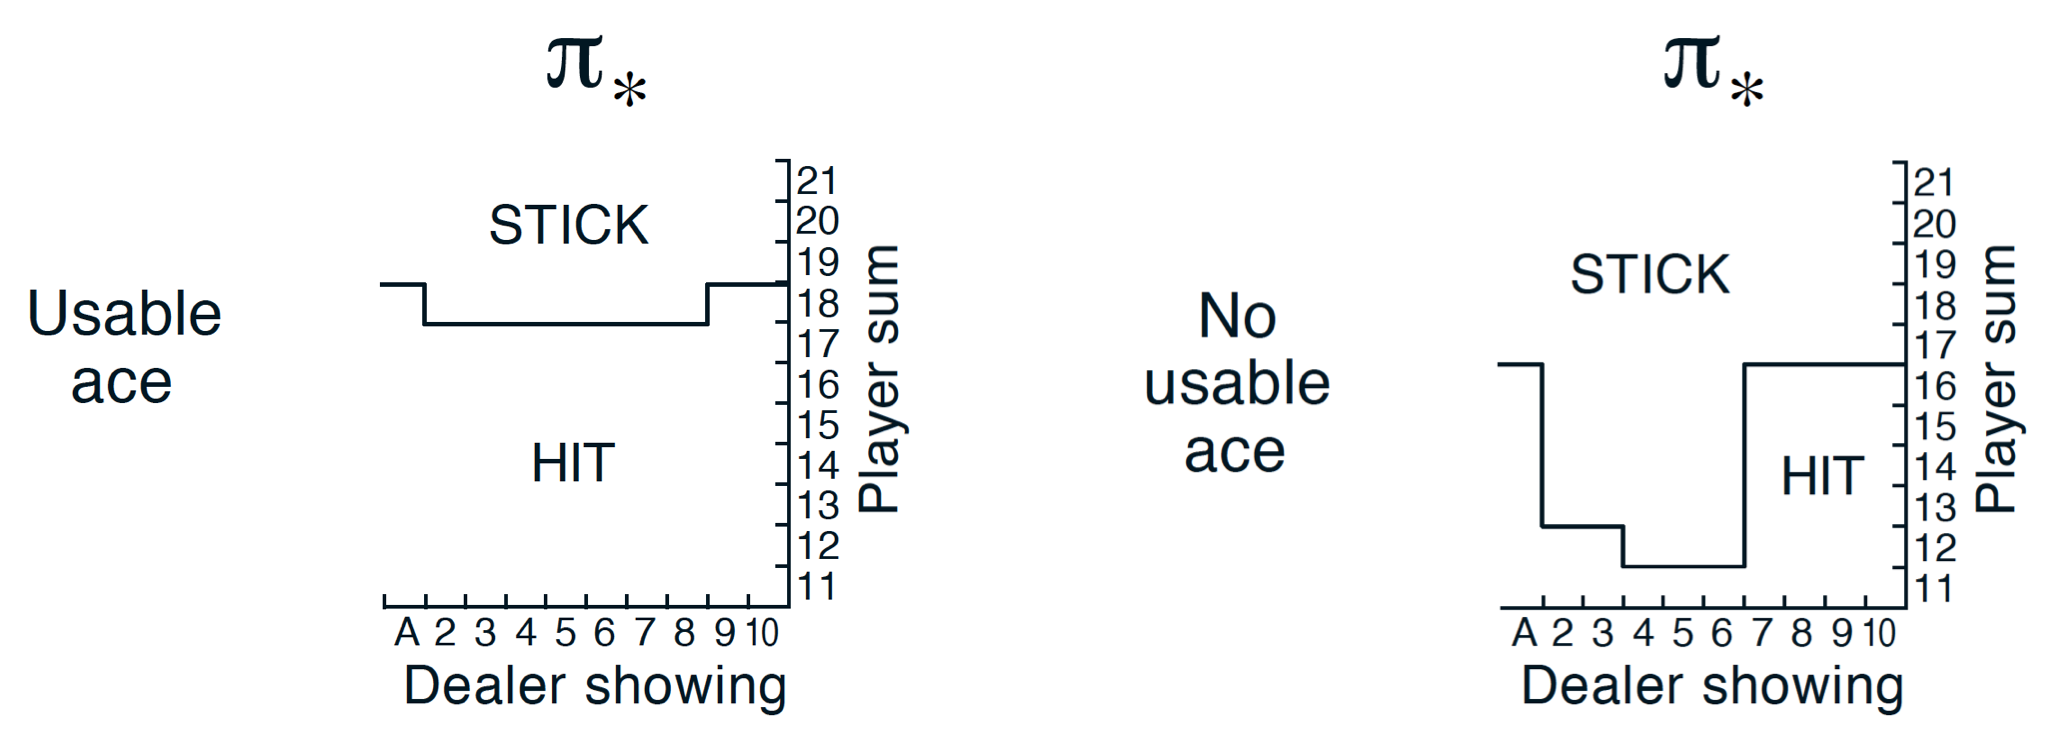

**Figura 2. Políticas óptimas.** Fuente: Sutton & Barto, 2018

A continuación os proporcionamos algunos escenarios de ejemplo extraídos de la figura:

| **Player_Sum** | **Dealer** | **Usable Ace** | **Action** |
|----------------|------------|----------------|------------|
| 17             | 5          | Yes            | HIT        |
| 19             | 2          | Yes            | STICK      |
| 18             | 9          | Yes            | HIT        |
| 20             | 9          | Yes            | STICK      |
| 5              | 2          | No             | HIT        |
| 14             | 2          | No             | STICK      |
| 11             | 4          | No             | HIT        |
| 12             | 6          | No             | STICK      |
| 5              | 7          | No             | HIT        |
| 17             | 8          | No             | STICK      |

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1</strong> (1 punto)</div>

Implementar un agente que ejecute la política óptima definida un poco más arriba. En el caso de la suma de las cartas del jugador sólo es necesario implementar a partir de 12 (incluído), ya que el entorno hace que siempre pida otra carta si está por debajo de ese valor.

In [11]:
# Inicializamos el entorno
env = bj1.BlackjackEnv()
obs = env.reset()
total_reward, done = 0, False

print("Obs inicial: Player = {}, Dealer = {}, Usable Ace = {} ".format(obs[0],obs[1],obs[2]))

switch_action = {
        0: "Stick",
        1: "Hit",
    }

Obs inicial: Player = 14, Dealer = 2, Usable Ace = False 


In [12]:
######################## SOLUCIÓN ###########################

class OptimalActionPolicyGetter(ActionPolicyGetter):
    def get_action(self, observation):    
        player_sum, dealer, usable_ace = observation

        if usable_ace:
            if player_sum >= 19:
                return 0
            elif player_sum >= 18 and (2 <= dealer <= 8):
                return 0
        else:
            if player_sum >= 17:
                return 0
            elif player_sum >= 13 and (2 <= dealer <= 3):
                return 0
            elif player_sum >= 12 and (4 <= dealer <= 6):
                return 0

        return 1

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2</strong> (0,5 puntos)</div>

Comprobación de resultados. Implementar una función que imprima la política por pantalla para comprobar que el agente implementado ejecuta correctamente la política óptima.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>NOTA:</strong> Tan sólo es necesario verificarlo para los estados de la Figura 2 (Player sum = 12-21, Dealer = 1-10, Usable/No usable ace).</div>

In [13]:
def observation_to_indeces(observation):
    """
    Convierte la observación en tres índices separados dentro de los rangos esperados
    """
    player_sum, dealer, usable_ace = observation
    # Se define i,j,k como los tres elementos que conforman el estado de cara a optimizar el indexado
    return player_sum-12, dealer-1, int(usable_ace)

def get_action_tables(policy):
    s = np.zeros((10,10,2), dtype='str')
    pi = np.zeros((10,10,2), dtype='int')

    for player_sum in range(12,22):
        for dealer in range(1,11):
            for usable_ace in [False, True]:
                obs = (player_sum, dealer, usable_ace)

                action = policy.get_action(obs)

                i,j,k = observation_to_indeces(obs)

                pi[i,j,k] = action
                if action == 0:
                    s[i,j,k] = 'S'
                else:
                    s[i,j,k] = 'H'

    return s, pi

def print_action_table(tables, title):
    fig, ax = plt.subplots(nrows=1, ncols=len(tables), figsize=(20,10))
    fig.suptitle(title, fontsize=20, y=0.92)
    
    for p, table in enumerate(tables):
        pi, s, title = table['pi'], table['s'], table['title']
        pi = np.flipud(pi)
        _im = ax[p].imshow(pi, extent=[0.5, 10.5, 11.5, 21.5], cmap='tab20')
        ax[p].set_xticks(np.arange(1,11))
        ax[p].set_yticks(np.arange(12,22))
        ax[p].set_title(title)
        ax[p].set_xlabel('Dealer showing')
        ax[p].set_ylabel('Player sum')
        for i in range(1,11):
            for j in range(12,22):
                _text = ax[p].text(i, j, s[j-12, i-1], ha="center", va="center")
        ax[p].set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 'T'])
        ax[p].set_yticklabels(np.arange(12,22))

    

def print_policy_opt(policy, title='Optimal Strategy'):
    s, pi = get_action_tables(policy)
    s_no_usable, s_usable = s[:,:,0], s[:,:,1]
    pi_no_usable, pi_usable = pi[:,:,0], pi[:,:,1]
    
    tables = [
        {
            "pi": pi_no_usable,
            "s": s_no_usable,
            "title": "No usable ace",
        },
        {
            "pi": pi_usable,
            "s": s_usable,
            "title": "Usable ace",
        }
    ]
    
    print_action_table(tables, title)

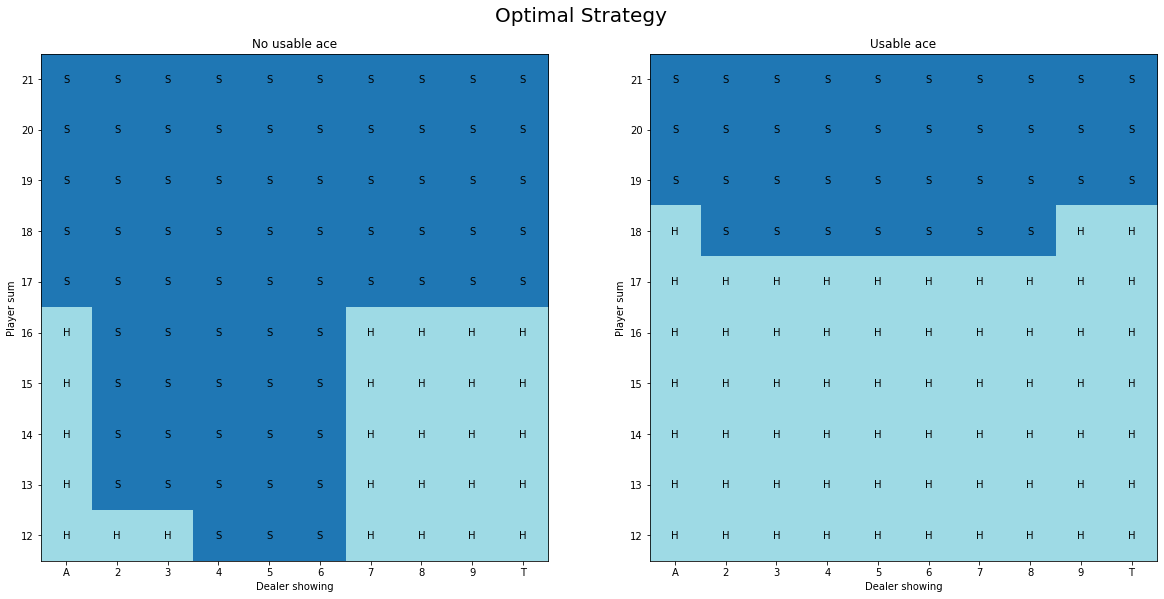

In [14]:
optimal_policy = OptimalActionPolicyGetter()
print_policy_opt(optimal_policy)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.3</strong> (0,5 puntos)</div>

Utilizando el agente y el entorno del apartado anterior, simular 100.000 partidas y calcular el retorno del agente (recompensa total acumulada).

Calculad el % de victorias, derrotas y empates y comentar las diferencias con respecto a la política del apartado 1.

In [15]:
def play_games(env, sample_policy, games):
######################## SOLUCIÓN ###########################
    victorias, derrotas, empates, recompensa_acumulada, total_reward = 0, 0, 0, 0, 0
    gamma = 1
    
    i=0 # Flag para contar las veces que procesa antes de encontrar el natural

    for i in tqdm(range(games), ncols=100, desc=f'Jugando {games} partidas'):
        _, rewards = create_episode(env, sample_policy)

        total_reward = sum(rewards)
    
        if total_reward == 1: victorias+=1
        elif total_reward == 0: empates+=1
        elif total_reward == -1: derrotas+=1
        
        recompensa_acumulada = recompensa_acumulada + (gamma**(i))*total_reward

        i+=1 # Actualiza el contador de iteraciones
        env.close()

    print(f"Victorias: {victorias*100/games}%\nDerrotas: {derrotas*100/games}%\nEmpates: {empates*100/games}%\nRecompensa acumulada: {recompensa_acumulada}")
    return victorias*100/games, derrotas*100/games, empates*100/games, recompensa_acumulada

In [16]:
games = 100000
_, _, _, _ = play_games(env, optimal_policy, games)

Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:17<00:00, 5717.51it/s]

Victorias: 43.125%
Derrotas: 47.344%
Empates: 9.531%
Recompensa acumulada: -4219


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
A pesar de estar utilizando la política óptima, el porcentaje de derrotas apenas se reduce en menos de un 3%. Las victorias, como en este caso no contempla la posibilidad de manos naturales ascienden levente a un 43%, por lo que a pesar de ser una política óptima, sigue siendo bastante mala.
</div>


## 3. Métodos de Montecarlo (2 puntos)

El objetivo de este apartado es realizar una estimación de la política óptima mediante los métodos de Montecarlo, en concreto estudiaremos el algoritmo 2 del módulo 5: *Control mediante métodos MC con exploraciones iniciales*. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.1</strong> (1 puntos)</div>

Implementar el Algoritmo 2 explicado en el módulo 5 "Métodos de Montecarlo", utilizando los siguientes parámetros:
    
- Número de episodios = 5.000.000
- Factor de descuento = 1

In [17]:
######################## SOLUCIÓN ###########################

class OptimizableActionPolicyGetter(ActionPolicyGetter):
    __slots__ = ("pi",)
    
    def __init__(self, pi) -> None:
        self.pi = pi
    
    def get_action(self, observation):
        player_sum, dealer, usable_ace = observation
        
        # Se define i,j,k como los tres elementos que conforman el estado de cara a optimizar el indexado
        i,j,k = player_sum-12, dealer-1, int(usable_ace)
        return self.pi[i,j,k]
    
    
def optimize_action_policy_getter_by_mc(episodes, gamma):
    start = time.time()
    pi = np.random.choice(a=[0, 1], size=(20,10,2))
    Q = np.random.rand(20,10,2,2)
    R_sum = np.empty((20,10,2,2), dtype='float')
    R_count = np.empty((20,10,2,2), dtype='int')

    policy = OptimizableActionPolicyGetter(pi)
    
    states_actions, rewards = [],[]

    # loop: forever (para cada episodio)
    for _ in tqdm(range(episodes), ncols=100, desc='Entrenando MC'):
        
        #Escoger S_0 ∈ S y A_0 ∈ A(s)
        s_0 = env.reset() # S_0
        a_0 = env.action_space.sample() # A_0
        
        # Implementación de la exploración inicial
        states_actions, rewards = create_episode(env, policy, s_0, a_0)

        G = 0
        T = len(rewards)
        
        for t in range(T-2, -1, -1): # T-1,T-2,...,0
            s_a = states_actions[t]
            a = states_actions[t][1]
            G = gamma*G + rewards[t+1]
            i,j,k = observation_to_indeces(s_a[0])
            
            if s_a not in states_actions[:t-1]:
                R_sum[i,j,k,a] += G
                R_count[i,j,k,a] += 1
                Q[i,j,k,a] = R_sum[i,j,k,a]/R_count[i,j,k,a]
                pi[i,j,k] = np.argmax(Q, axis=3)[i,j,k]
            
    finish = time.time()
    print(f"Tiempo insumido: {str(datetime.timedelta(seconds=(round(finish-start,0))))}")
    
    return policy

In [18]:
episodes = 5000000
gamma = 1
mc_policy = optimize_action_policy_getter_by_mc(episodes, gamma)

Entrenando MC: 100%|████████████████████████████████████| 5000000/5000000 [13:37<00:00, 6116.26it/s]

Tiempo insumido: 0:13:37


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.2</strong> (0,5 puntos)</div>

Implementar una función que imprima por pantalla la política óptima encontrada para cada estado.

¿Se consigue llegar a la política óptima?

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>NOTA:</strong> Para responder a la pregunta se recomienda implementar una función que compare la política obtenida para el conjunto de estados de la figura 2 con la política óptima e indique el número de acciones no óptimas (si las hay).</div>

In [19]:
def print_policy_MC(policy):
    print_policy_opt(policy, "Montecarlo strategy")

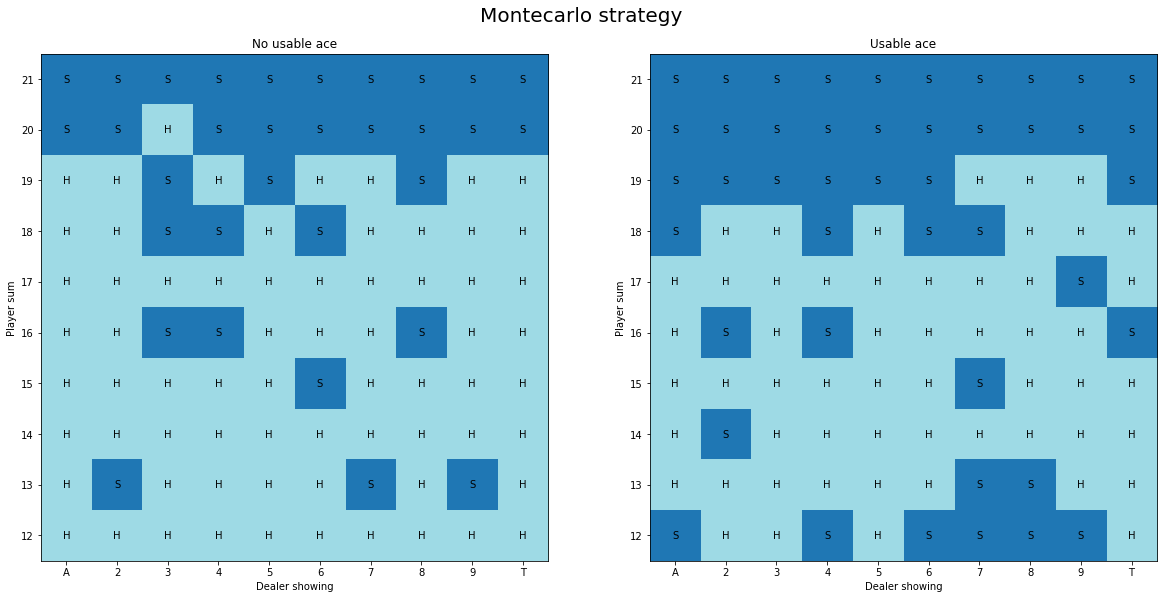

In [20]:
print_policy_MC(mc_policy)

In [21]:
def compara_mc(policy):

    ######################## SOLUCIÓN ###########################
    _, optimal_pi = get_action_tables(optimal_policy)
    _, policy_pi = get_action_tables(policy)
    
    # Se compara uno a uno los valores de la política
    cmp_pi = (optimal_pi != policy_pi)
    return np.sum(cmp_pi)

In [22]:
errors = compara_mc(mc_policy)
print(f"Número total de errores = {errors}/200")

Número total de errores = 69/200


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    La diferencia entre la política óptima y la encontrada mediante el entrenamiento del agente utilizando un método de Montecarlo tiene una diferencia de 69 casos en las 200 posibilidades disponibles (34.5% de errores) o, desde el otro lado, podríamos decir que acierta en un total de 131 casos con respecto a la política óptima (65.5% de acierto).
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.3</strong> (0,5 puntos)</div>

Utilizando el agente obtenido mediante el método de MC, simular 100.000 partidas y calcular el retorno del agente (recompensa total acumulada).

Calculad el % de victorias, derrotas y empates y compararlos con los del apartado 2. ¿A qué se deben las posibles diferencias?

In [23]:
######################## SOLUCIÓN ###########################
def play_games_mc(env, mc_policy, games):
    return play_games(env, mc_policy, games)

In [24]:
games = 100000
_, _, _, _ = play_games_mc(env, mc_policy, games)

Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:20<00:00, 4969.13it/s]

Victorias: 32.787%
Derrotas: 60.88%
Empates: 6.333%
Recompensa acumulada: -28093


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Utilizando el agente generado con Montecarlo, nos encontramos con un índice de derrotas de casi 2 de cada 3 partidas jugadas. Es decir, estamos frente a una política peor que la aleatoria que utilizamo en el ejercicio 1 y, por descontado, aún peor que la óptima con una diferencia de derrotas que supera el 12%.
</div>

## 4. Métodos de Diferencia Temporal (2 puntos)

El objetivo de este apartado es realizar una estimación de la política óptima mediante los métodos de Diferencia Temporal en el entorno Blackjack comentado anteriormente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1</strong> (1,5 punto)</div>

Implementar el algoritmo *SARSA* explicado en el modulo 6 "Aprendizaje por Diferencia Temporal" y ejecutarlo utilizando los siguientes parámetros (1 punto):
    
- Número de episodios = 1.000.000
- *learning rate* = 0,001
- *discount factor* = 1
- *epsilon* = 1/(nº de episodio)
- *mínimo valor de epsilon* = 0,2 

Imprimir una gráfica con la evolución del mayor error TD de cada episodio (0,5 puntos).

In [25]:
######################## SOLUCIÓN ###########################
#Cargamos el entrono
env = bj1.BlackjackEnv()
print(f"Action space is {env.action_space} ")
print(f"Observation space is {env.observation_space} ")
print(f"Reward range is {env.reward_range} ")

Action space is Discrete(2) 
Observation space is Tuple(Discrete(32), Discrete(11), Discrete(2)) 
Reward range is (-inf, inf) 


In [26]:
######################## SOLUCIÓN ###########################

class EpsilonGreedyActionPolicyGetter(ActionPolicyGetter):
    '''
    Implementación de la política ε-greedy
    '''

    __slots__ = ("Q", "epsilon", "env")
    
    def __init__(self, Q, epsilon, environment) -> None:
        # Asignar los parámetros
        super().__init__()
        self.Q = Q
        self.epsilon = epsilon
        self.env = environment
    
    def get_action(self, observation):
        # Se elige una acción aleatoria
        if np.random.uniform(0,1) < self.epsilon:
            return env.action_space.sample()
        # Se elige una acción tomando la política greedy
        else:
            i,j,k = observation_to_indeces(observation)
            return np.argmax(self.Q[i,j,k,:]) # devuelve el índice del máximo valor estado-acción

    
def optimize_action_policy_getter_by_sarsa(episodes, alpha, gamma, epsilon, epsilon_min):
    start = time.time()
    
    #Almacenamiento del error temporal δt
    delta = []
    
    # Inicializar arbitrariamente Q(s,a),∀s ∈ S+,a ∈ A(s), excepto Q(terminal,·) = 0
    Q = np.random.rand(20, 10, 2, 2)
    Q[19,:,:,:] = 0.0

    epsilon_greedy_policy = EpsilonGreedyActionPolicyGetter(Q, epsilon, env)
    
    # for cada episodio do
    for _ in tqdm(range(episodes), ncols=100, desc='Entrenando SARSA'):
        
        # Inicializar S
        state = env.reset()
        done = False
        
        # Elegir A desde S usando la política derivada de Q (p.e., ε-greedy)
        action = epsilon_greedy_policy.get_action(state)
        
        # Define error
        error = 0
        
        # for cada paso t del episodio hasta S terminal do
        while not done:
            # Ejecutar la acción A, observar R, S′
            next_state, reward, done, _ = env.step(action)
            
            # Elegir A′ desde S′ usando la política derivada de Q (p.e., ε-greedy)
            next_action = epsilon_greedy_policy.get_action(next_state)
            
            # Get the v value
            i,j,k = observation_to_indeces(state)
            x,y,z = observation_to_indeces(next_state)

            # Get Q
            q = Q[i,j,k, action] # Q(S,A)
            qp = Q[x,y,z,next_action] # Q(S',A')
            
            # Q(S,A) <- Q(S,A) + α[R + γQ(S′,A′) – Q(S,A)]
            q_new = Q[i,j,k,action] = q + alpha*(reward + gamma * qp - q)
            
            # Calculate error
            error = max(error, abs(q-q_new))
                
            # S <- S′ ; A <- A′
            state = next_state
            action = next_action
            
        # Error TD del instante t+1
        delta.append(error)
        
    finish = time.time()
    print(f"Tiempo insumido: {str(datetime.timedelta(seconds=(round(finish-start,0))))}")
    
    return epsilon_greedy_policy, delta

In [27]:
######################## SOLUCIÓN ###########################
# -> Parámetros de prueba

episodes = 1000000                  # Número de episodios = 1.000.000
alpha = 0.001                       # learning rate (lr) = 0,001
gamma = 1                           # discount factor = 1
epsilon = 1/episodes                # epsilon = 1/(nº de episodio)
epsilon_min = 0.2                   # mínimo valor de epsilon = 0,2 ¿alpha?

Q_sarsa, deltas = optimize_action_policy_getter_by_sarsa(episodes, alpha, gamma, epsilon, epsilon_min)

Entrenando SARSA: 100%|█████████████████████████████████| 1000000/1000000 [04:11<00:00, 3968.98it/s]

Tiempo insumido: 0:04:12


Text(0, 0.5, 'Delta')

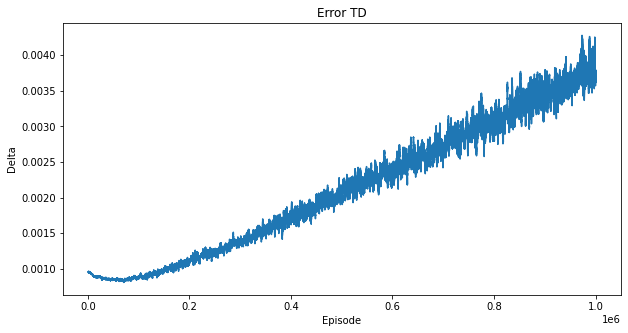

In [28]:
######################## SOLUCIÓN ###########################
smooth_deltas = pd.Series(deltas).rolling(window=1000, min_periods=1000).mean()

# -> Gráfica con la evolución del mayor error 
fig = plt.figure(figsize=(10,5))
plt.plot(smooth_deltas)
plt.title("Error TD")
plt.xlabel('Episode')
plt.ylabel('Delta')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.2</strong> (0,25 puntos)</div>

Implementar una función que imprima por pantalla la política óptima encontrada para cada estado.

¿Se consigue llegar a la política óptima?

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>NOTA:</strong> Para responder a la pregunta se recomienda implementar una función que compare la política obtenida para el conjunto de estados de la figura 2 con la política óptima e indique el número de acciones no óptimas (si las hay).</div>

In [29]:
def print_policy_SARSA(q):

######################## SOLUCIÓN ###########################
    print_policy_opt(q, "SARSA strategy")

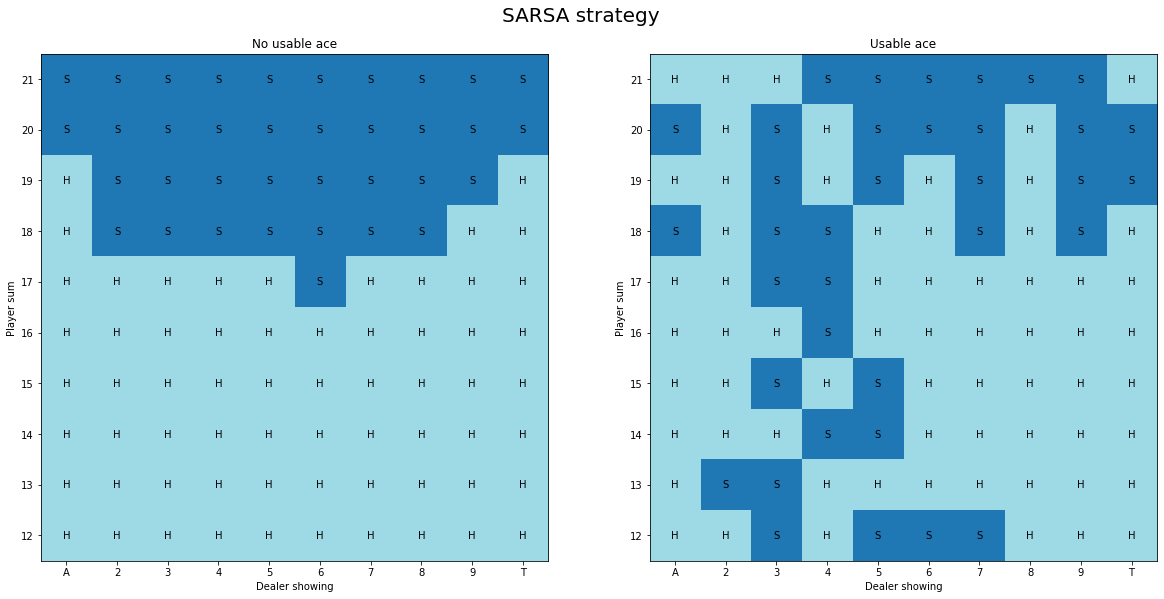

In [30]:
print_policy_SARSA(Q_sarsa)

In [31]:
def compara_sarsa(q):
    ######################## SOLUCIÓN ###########################
    _, optimal_pi = get_action_tables(optimal_policy)
    _, policy_pi = get_action_tables(q)
    
    # Se compara uno a uno los valores de la política
    cmp_pi = (optimal_pi != policy_pi)
    return np.sum(cmp_pi)

In [32]:
errors = compara_sarsa(Q_sarsa)
print(f"Número total de errores = {errors}/200")

Número total de errores = 68/200


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Utilizando el algoritmo SARSA, se obtiene una política levemente mejor que con Montecarlo, donde la diferencia es de apenas una acción en favor del primero. Sin embargo, la principal diferencia está en que para las manos con No-usable-ace, la política es bastante similar y mucho más correcta, mientras que para el caso de usable-ace, en la gráfica anterior puede verse algo mucho más aleatorio.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.3</strong> (0,25 puntos)</div>

Utilizando el agente obtenido mediante el método de SARSA, simular 100.000 partidas y calcular el retorno del agente (recompensa total acumulada).

¿Se aprecian grandes diferencias en los porcentajes obtenidos? ¿A qué es debido?

In [33]:
######################## SOLUCIÓN ###########################
def play_games_sarsa(env, Q_sarsa, games):
    return play_games(env, Q_sarsa, games)

In [34]:
_, _, _, _ = play_games_sarsa(env, Q_sarsa, games=100000)

Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:22<00:00, 4433.32it/s]

Victorias: 35.537%
Derrotas: 56.471%
Empates: 7.992%
Recompensa acumulada: -20934


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
A través de SARSA se consiguen mejores resultados que con Montecarlo, en el entorno del 56%. Aunque sigue sin ser sustancialmente mejor, queda a mitad de camino entre la política óptima y la alcanzada por Montecarlo.
</div>


## 5. Comparativa de los algoritmos (2 puntos)

En este apartado realizaremos una comparativa entre los algoritmos.

Compararemos el comportamiento de los algoritmos al modificar los valores del factor de descuento, el *learning rate* (en el caso del método SARSA) y el numero de episodios.

Para cada ejercicio se deben mostrar y justificar los resultados.

<u>NOTA</u>: se recomienda realizar varias veces las simulaciones en cada ejercicio, ya que éstas son aleatorias, y comentar el resultado más frecuente, o una media de estos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 5.1-Influencia del número de episodios</strong> (1 punto)</div> 

Realizar un estudio cambiando el número de episodios en cada uno de los 2 algoritmos:
- Entrenar cada algoritmo varias veces con 100.000, 1.000.0000 y 5.000.000 de episodios y promediar los resultados
- Indicar cómo influye el número de episodios en la convergencia de cada algoritmo, calculando el número de estados en que la política difiere de la óptima así como la media del retorno obtenido al jugar 100.000 partidas después de cada entrenamiento.

In [35]:
######################## SOLUCIÓN ###########################
metrics = ['victorias', 'derrotas', 'empates', 'recompensas']
episodes = [100000, 1000000, 5000000]

alpha = 1
gamma = 1 # factor de descuento
total_games = 100000 # total de jugadas para análisis de cada algoritmo
epsilon_min = 0.2

montecarlo = {}
sarsa = {}

for episode in episodes:
    montecarlo[str(episode)] = {}
    sarsa[str(episode)] = {}
    for m in metrics:
        montecarlo[str(episode)][m] = []
        sarsa[str(episode)][m] = []

# Entrenamiento y prueba con todos los casos de Montecarlo
for episode in episodes:
    
    # Entrenmiento del algoritmo con tantos episodios como determine episode
    mc_policy_5_1 = optimize_action_policy_getter_by_mc(episode, gamma)
    
    # Prueba de resultados, para 100k jugadas
    v, d, e, r = play_games_mc(env, mc_policy_5_1, total_games)
    montecarlo[str(episode)]['victorias'].append(v)
    montecarlo[str(episode)]['derrotas'].append(d)
    montecarlo[str(episode)]['empates'].append(e)
    montecarlo[str(episode)]['recompensas'].append(r)
    
    
    # Se define dentro del bucle por la dependencia con la cantidad de episodios
    epsilon = 1/episode
    
    # Entrenmiento del algoritmo con tantos episodios como determine episode
    Q_sarsa_5_1, _ = optimize_action_policy_getter_by_sarsa(episode, alpha, gamma, epsilon, epsilon_min)
    
    # Prueba de resultados, para 100k jugadas
    v, d, e, r = play_games_sarsa(env, Q_sarsa_5_1, total_games)
    sarsa[str(episode)]['victorias'].append(v)
    sarsa[str(episode)]['derrotas'].append(d)
    sarsa[str(episode)]['empates'].append(e)
    sarsa[str(episode)]['recompensas'].append(r)
    
        
# Se promedian los resultados finales
for episode in episodes:
    
    montecarlo[str(episode)]['victorias'] = str(statistics.mean(montecarlo[str(episode)]['victorias']))+"%"
    montecarlo[str(episode)]['derrotas'] = str(statistics.mean(montecarlo[str(episode)]['derrotas']))+"%"
    montecarlo[str(episode)]['empates'] = str(statistics.mean(montecarlo[str(episode)]['empates']))+"%"
    montecarlo[str(episode)]['recompensas'] = sum(montecarlo[str(episode)]['recompensas'])
    
    sarsa[str(episode)]['victorias'] = str(statistics.mean(sarsa[str(episode)]['victorias']))+"%"
    sarsa[str(episode)]['derrotas'] = str(statistics.mean(sarsa[str(episode)]['derrotas']))+"%"
    sarsa[str(episode)]['empates'] = str(statistics.mean(sarsa[str(episode)]['empates']))+"%"
    sarsa[str(episode)]['recompensas'] = sum(sarsa[str(episode)]['recompensas'])
    

Entrenando MC: 100%|██████████████████████████████████████| 100000/100000 [00:16<00:00, 5935.75it/s]


Tiempo insumido: 0:00:17


Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:17<00:00, 5598.25it/s]


Victorias: 37.631%
Derrotas: 55.326%
Empates: 7.043%
Recompensa acumulada: -17695


Entrenando SARSA: 100%|███████████████████████████████████| 100000/100000 [00:23<00:00, 4328.35it/s]


Tiempo insumido: 0:00:23


Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:23<00:00, 4290.94it/s]


Victorias: 33.613%
Derrotas: 58.741%
Empates: 7.646%
Recompensa acumulada: -25128


Entrenando MC: 100%|████████████████████████████████████| 1000000/1000000 [02:47<00:00, 5987.90it/s]


Tiempo insumido: 0:02:47


Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:18<00:00, 5453.78it/s]


Victorias: 38.542%
Derrotas: 54.38%
Empates: 7.078%
Recompensa acumulada: -15838


Entrenando SARSA: 100%|█████████████████████████████████| 1000000/1000000 [04:19<00:00, 3853.36it/s]


Tiempo insumido: 0:04:20


Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:21<00:00, 4677.69it/s]


Victorias: 33.626%
Derrotas: 59.001%
Empates: 7.373%
Recompensa acumulada: -25375


Entrenando MC: 100%|████████████████████████████████████| 5000000/5000000 [10:50<00:00, 7685.80it/s]


Tiempo insumido: 0:10:51


Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:17<00:00, 5867.31it/s]


Victorias: 41.637%
Derrotas: 50.496%
Empates: 7.867%
Recompensa acumulada: -8859


Entrenando SARSA: 100%|█████████████████████████████████| 5000000/5000000 [18:02<00:00, 4617.58it/s]


Tiempo insumido: 0:18:03


Jugando 100000 partidas: 100%|████████████████████████████| 100000/100000 [00:21<00:00, 4745.24it/s]

Victorias: 34.584%
Derrotas: 58.007%
Empates: 7.409%
Recompensa acumulada: -23423


In [36]:
print("Montecarlo: "+json.dumps(montecarlo, indent=4))
print("\nSARSA: "+json.dumps(sarsa, indent=4))

Montecarlo: {
    "100000": {
        "victorias": "37.631%",
        "derrotas": "55.326%",
        "empates": "7.043%",
        "recompensas": -17695
    },
    "1000000": {
        "victorias": "38.542%",
        "derrotas": "54.38%",
        "empates": "7.078%",
        "recompensas": -15838
    },
    "5000000": {
        "victorias": "41.637%",
        "derrotas": "50.496%",
        "empates": "7.867%",
        "recompensas": -8859
    }
}

SARSA: {
    "100000": {
        "victorias": "33.613%",
        "derrotas": "58.741%",
        "empates": "7.646%",
        "recompensas": -25128
    },
    "1000000": {
        "victorias": "33.626%",
        "derrotas": "59.001%",
        "empates": "7.373%",
        "recompensas": -25375
    },
    "5000000": {
        "victorias": "34.584%",
        "derrotas": "58.007%",
        "empates": "7.409%",
        "recompensas": -23423
    }
}


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>CONCLUSIONES:</strong>
<br><br>

    Para ambos algoritmos, los resultados aparecen promediados para victorias, derrotas y empates, y la suma total en el campo recompensas.
    
Algoritmo MC:  
    
    A través del algoritmo de Montcarlo, el porcentaje de derrotas va descendiendo conforme más casos de entrenamiento dispone el agente previo a jugar las 100k partidas, tal es así que puede verse que a medida que entrena con más casos, van descendiendo del 55% al 50%. Las victorias, por su parte, van ascendiendo del 37% a más del 41%, mientras que los empates se mantienen constantes. Las recomensas van mejorando de una forma significativa a medida que los casos de entrenamiento son más. 
    
Algoritmo SARSA: 

    El algoritmo SARSA por el contrario, mantiene estabilizadas las derrotas en el entorno del 59% independientemente del número de casos de entrenamiento, así como las victorias y empates que tampoco varían del 34% y 7.5% respectivamente. Las recompensas también se mantienen estables en el orden de -25k, independiente del número de casos de entrenamiento.
</div>

A partir de estos resultados, podríamos decir que el método de Montecarlo es susceptible al número de entrenamientos del que dispone el agente, mientras que el SARSA parece ser indiferente. Además, si se dispusiera de tiempo, creo que podríamos acercarnos a la política óptima a través de Montecarlo mucho más rápido que con SARSA, condicionado a un valor gamma=1, es decir, que las recompensas futuras son igual de importantes que las inmediatas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 5.2-Influencia del factor de descuento</strong> (0,5 puntos)</div> 

Ejecutar los 2 algoritmos con *discount factor*=0.1 y el resto de parámetros iguales que en los ejercicios 3 y 4. Describir los cambios en la política óptima, comparando el resultado obtenido con el resultado de los ejercicios 3 y 4 (*discount factor*=1).


In [37]:
######################## SOLUCIÓN ###########################
episodes_mc = 5000000               # Número de episodios MC = 5.000.000
episodes_sarsa = 1000000            # Número de episodios SARSA = 1.000.000
alpha = 0.001                       # learning rate (lr) = 0,001
gamma = 0.1                         # discount factor = 1
epsilon = 1/episodes_sarsa          # epsilon = 1/(nº de episodio)
epsilon_min = 0.2                   # mínimo valor de epsilon = 0,2

mc_policy_5_2 = optimize_action_policy_getter_by_mc(episodes_mc, gamma)
errors_mc = compara_mc(mc_policy_5_2)

Q_sarsa_5_2, _ = optimize_action_policy_getter_by_sarsa(episodes_sarsa, alpha, gamma, epsilon, epsilon_min)
errors_sarsa = compara_sarsa(Q_sarsa_5_2)

Entrenando MC: 100%|████████████████████████████████████| 5000000/5000000 [10:56<00:00, 7619.89it/s]


Tiempo insumido: 0:10:56


Entrenando SARSA: 100%|█████████████████████████████████| 1000000/1000000 [03:25<00:00, 4877.00it/s]

Tiempo insumido: 0:03:25


In [38]:
print(f"Número total de errores = {errors_mc}/200")
print(f"Número total de errores = {errors_sarsa}/200")

Número total de errores = 33/200
Número total de errores = 37/200


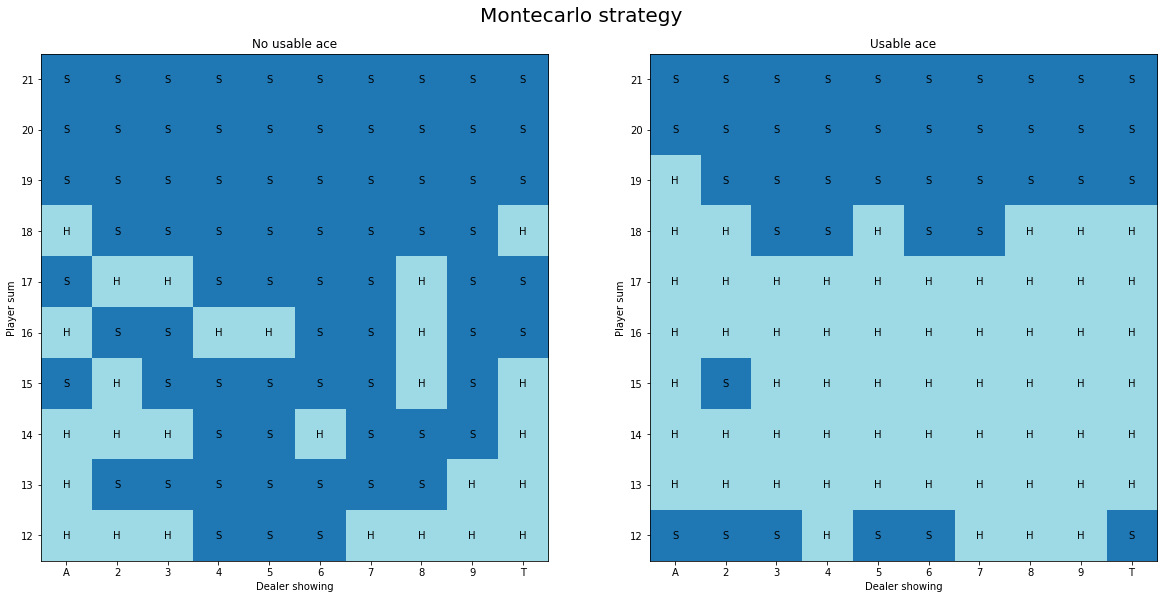

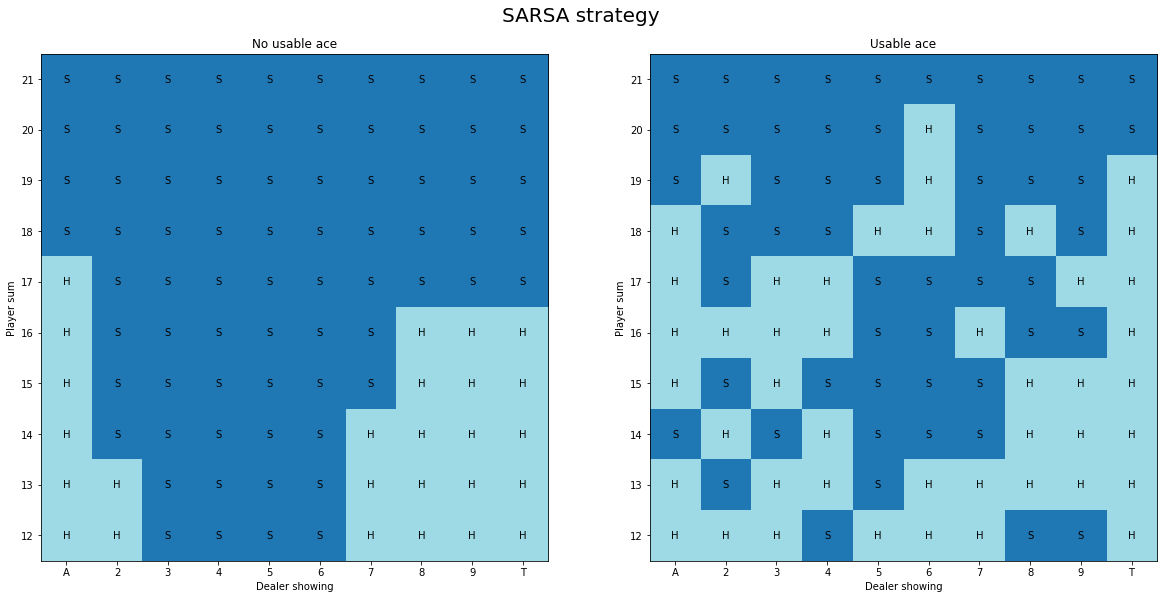

In [39]:
print_policy_MC(mc_policy_5_2)
print_policy_SARSA(Q_sarsa_5_2)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>CONCLUSIONES:</strong>
<br>
    De los errores obtenidos anteriormente podemos decir que el método de Montecarlo aproxima mejor a la política óptima pero con un total de cinco millones de casos de entrenamiento, mientas que el SARSA es apenas un 2% peor pero reduciendo los casos a un millón, una quinta parte. También creo importante destacar que el algoritmo SARSA ha aproximado realmente bien, a la política óptima para el caso de No-usable-ace. Podemos concluir entonces que, para este juego, la influencia del factor de descuento es vinculante, puesto que al reducir este valor en una décima parte, prioriza las recompensas inmediatas y mejora la búsqueda de la política óptima. Quizá se podría pensar, que al tener partidas mayoritariamente de entre uno y dos Hits, las recompensas inmediatas son mucho más importantes que aquellas futuras.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 5.3-Influencia del learning rate</strong> (0,5 puntos)</div> 

Ejecutar el algoritmo de *SARSA* con los siguientes valores de *learning rate*: 0.001, 0.01, 0.1 y 0.9. Analizar las diferencias con los resultados obtenidos en la pregunta 4 en término de número de errores respecto a la política óptima y de recompensa acumulada cada 100.000 episodios jugados.

Entrenando SARSA: 100%|███████████████████████████████████| 100000/100000 [00:20<00:00, 4939.48it/s]


Tiempo insumido: 0:00:20
Número total de errores con lr=0.001 : 77/200


Entrenando SARSA: 100%|███████████████████████████████████| 100000/100000 [00:20<00:00, 4959.71it/s]


Tiempo insumido: 0:00:20
Número total de errores con lr=0.01 : 63/200


Entrenando SARSA: 100%|███████████████████████████████████| 100000/100000 [00:20<00:00, 4795.25it/s]


Tiempo insumido: 0:00:21
Número total de errores con lr=0.9 : 73/200


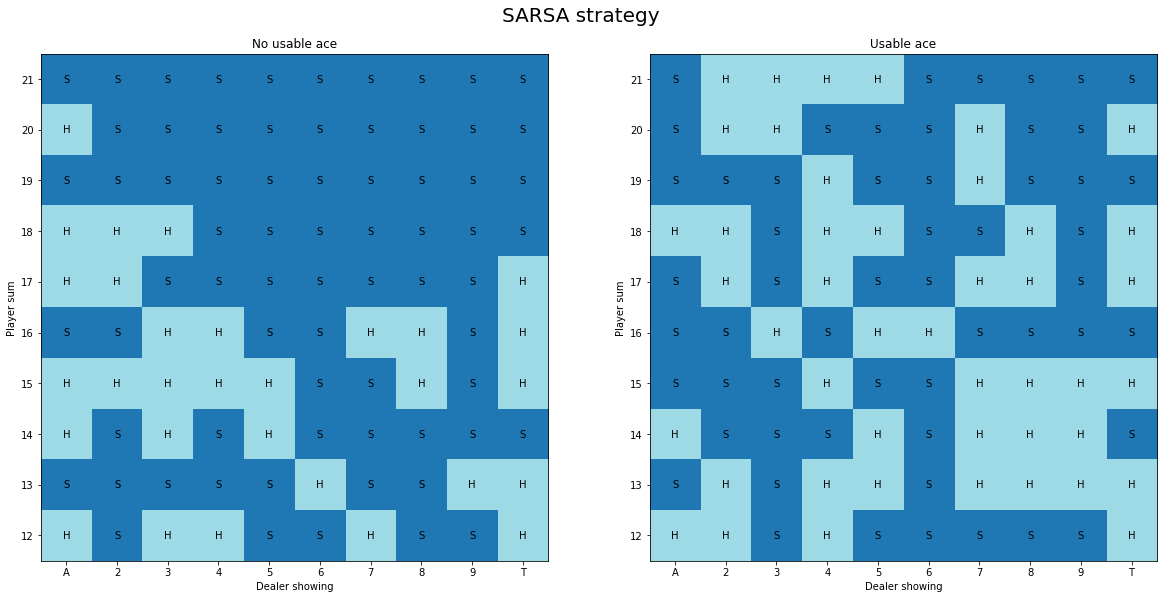

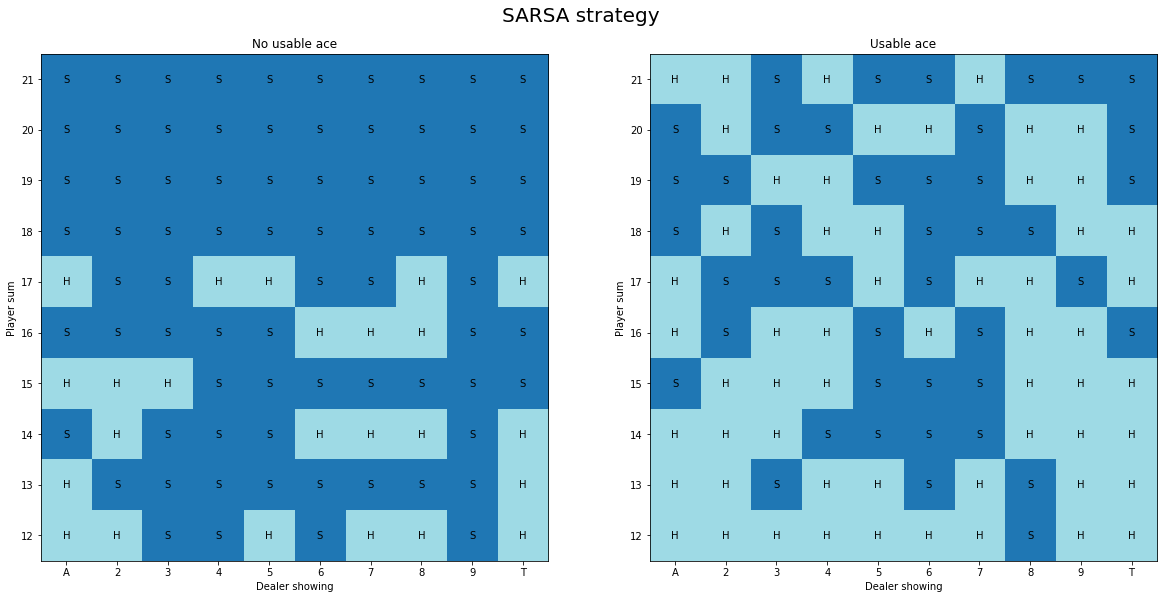

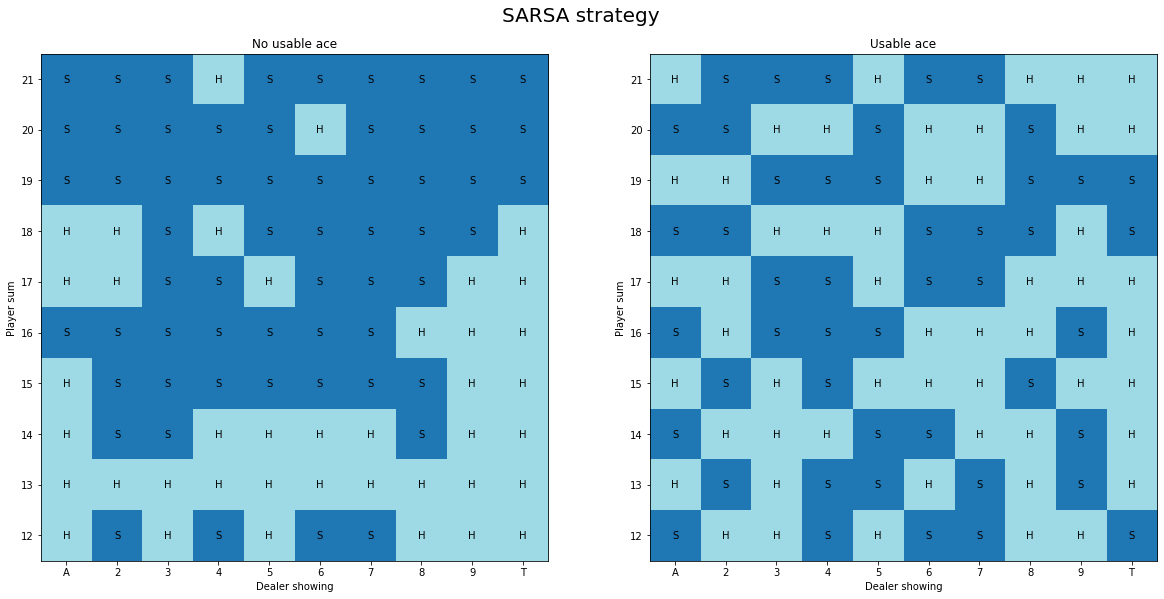

In [40]:
######################## SOLUCIÓN ###########################

episodes = 100000                   # Número de episodios = 100.000
alpha = 0.001                       # learning rate (lr) = 0,001
gamma = [0.001, 0.01, 0.9]          # discount factor = 1
epsilon = 1/episodes                # epsilon = 1/(nº de episodio)
epsilon_min = 0.2                   # mínimo valor de epsilon = 0,2 ¿alpha?

for g in gamma:
    Q_sarsa_5_3, _ = optimize_action_policy_getter_by_sarsa(episodes, alpha, g, epsilon, epsilon_min)
    errors = compara_sarsa(Q_sarsa_5_3)
    print(f"Número total de errores con lr={g} : {errors}/200")

    print_policy_SARSA(Q_sarsa_5_3)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>CONCLUSIONES:</strong>
<br><br>
    Al variar el learning rate se ha empeorado el algoritmo SARSA, puesto que el nivel de diferencia entre ellos con respecto a la política óptima está en el entorno del 35%, frente al 15% que encontramos en el apartado anterior.
</div>